In [1]:
!pip install tf-nightly
!pip install tensorflow-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.__version__)

import tensorflow_hub as hub
import os
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D
from tensorflow.python.keras import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras import layers

2.15.0-dev20230924


In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.15.0-dev20230924
Eager mode:  True
Hub version:  0.14.0
GPU is NOT AVAILABLE


In [4]:
import os
import zipfile
from google.colab import drive
from io import BytesIO

drive.mount('/content/gdrive')

zip_file_path = os.path.join('/content/gdrive/My Drive/Dataset/PlantImages.zip')

# Download the zipfile to Colab
with open(zip_file_path, 'rb') as f:
  zip_file_data = f.read()

# Create a zipfile object from the zip file data
zip_file = zipfile.ZipFile(BytesIO(zip_file_data))

# Define the target extraction directory in /root/.keras/datasets/
target_extraction_dir = '/root/.keras/datasets/PlantImages'

# Extract the files in the zipfile to the target directory
zip_file.extractall(target_extraction_dir)

# List the extracted files in the target directory
extracted_files = os.listdir(target_extraction_dir)

data_dir = os.path.join(target_extraction_dir, 'PlantImages')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
print(extracted_files)

Mounted at /content/gdrive
['validation', 'train']


In [10]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [11]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /root/.keras/datasets/PlantImages/train : 848files
total images for validation : /root/.keras/datasets/PlantImages/validation : 153files


In [12]:
classes = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']
print('Number of classes:',len(classes))

Number of classes: 19


In [13]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [14]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 153 images belonging to 19 classes.
Found 848 images belonging to 19 classes.


In [16]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [17]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False

In [18]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 19)                9747      
                                                                 
Total params: 22861619 (87.21 MB)
Trainable params: 1058835 (4.04 MB)
Non-trainable params: 21802784 

In [19]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [24]:
# Calculate the number of steps for training and validation
train_steps = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Check if there are any remaining samples that don't fit into a full batch
if train_generator.samples % train_generator.batch_size != 0:
    train_steps += 1

if validation_generator.samples % validation_generator.batch_size != 0:
    validation_steps += 1

# Now, use these calculated values in the model.fit_generator call
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


<ipython-input-24-c1be2fa9fd06>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
14/14 [==============================] - 292s 20s/step - loss: 1.1357 - accuracy: 0.5873 - val_loss: 1.0945 - val_accuracy: 0.6209
Epoch 2/5
14/14 [==============================] - 265s 19s/step - loss: 0.7807 - accuracy: 0.7134 - val_loss: 0.9686 - val_accuracy: 0.6601
Epoch 3/5
14/14 [==============================] - 264s 19s/step - loss: 0.6653 - accuracy: 0.7748 - val_loss: 0.7224 - val_accuracy: 0.7778
Epoch 4/5
14/14 [==============================] - 301s 22s/step - loss: 0.5550 - accuracy: 0.8054 - val_loss: 0.5899 - val_accuracy: 0.8235
Epoch 5/5
14/14 [==============================] - 302s 23s/step - loss: 0.4748 - accuracy: 0.8479 - val_loss: 0.4618 - val_accuracy: 0.8824


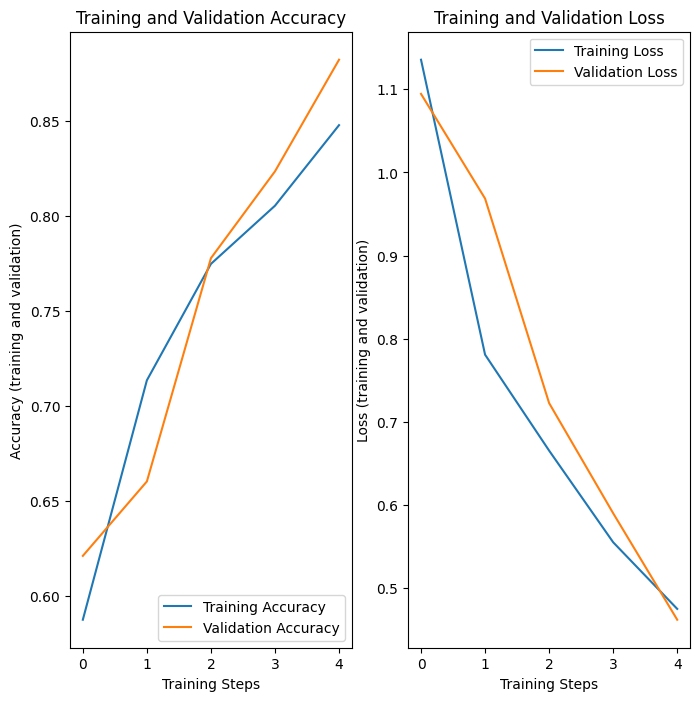

In [25]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [26]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255

    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: 3, file: 3/UNADJUSTEDNONRAW_thumb_12c.jpg
1/1 [==============================] - 3s 3s/step
PREDICTED: class: 12, confidence: 0.668193


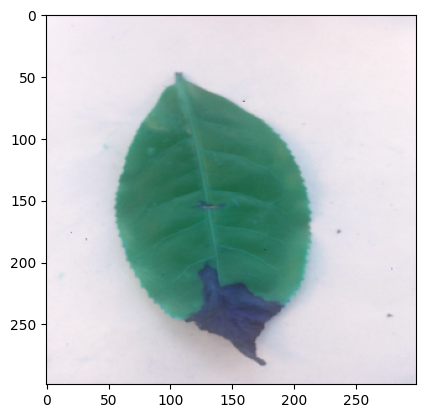

<Figure size 640x480 with 0 Axes>

SOURCE: class: 11, file: 11/RRDI_Blast3.jpg
1/1 [==============================] - 0s 373ms/step
PREDICTED: class: 3, confidence: 0.451606


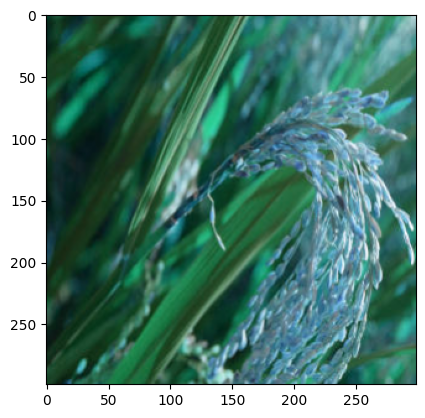

SOURCE: class: 13, file: 13/brownspot3-1024x683.jpg
1/1 [==============================] - 0s 382ms/step
PREDICTED: class: 5, confidence: 0.429922


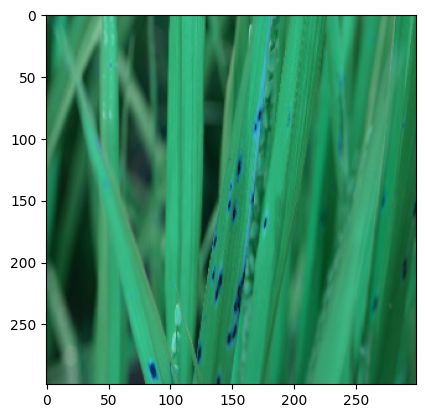

<Figure size 640x480 with 0 Axes>

SOURCE: class: 6, file: 6/UNADJUSTEDNONRAW_thumb_9a.jpg
1/1 [==============================] - 0s 223ms/step
PREDICTED: class: 11, confidence: 0.405413


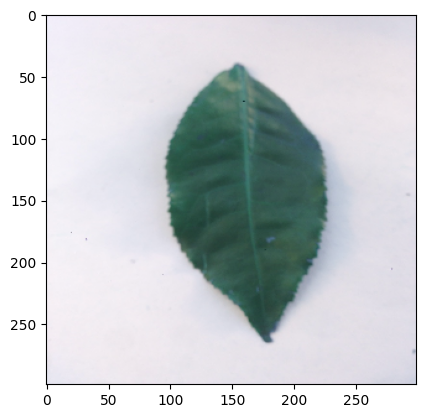

<Figure size 640x480 with 0 Axes>

SOURCE: class: 4, file: 4/IMG_20220503_135841.jpg
1/1 [==============================] - 0s 212ms/step
PREDICTED: class: 13, confidence: 0.879061


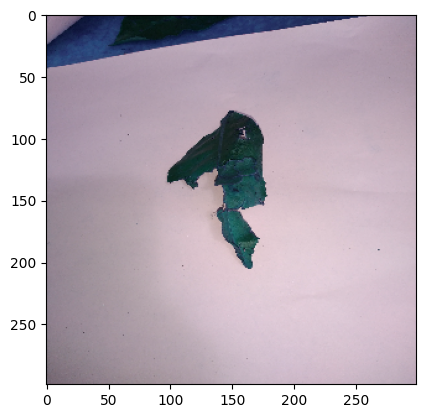

<Figure size 640x480 with 0 Axes>

In [27]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [28]:
import time
import tensorflow as tf

# Define your model here
# model = ...

# Generate a timestamp for the export path
t = int(time.time())

# Define the export path
export_path = "/tmp/saved_models/{}".format(t)+"latest"

# Save the model
model.save(export_path)

print("Model saved to:", export_path)


Model saved to: /tmp/saved_models/1695551720latest


In [29]:
import tensorflow as tf
import tensorflow_hub as hub

reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer': hub.KerasLayer})


In [30]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: 6, file: 6/UNADJUSTEDNONRAW_thumb_7d.jpg
1/1 [==============================] - 0s 224ms/step
PREDICTED: class: 15, confidence: 0.892990


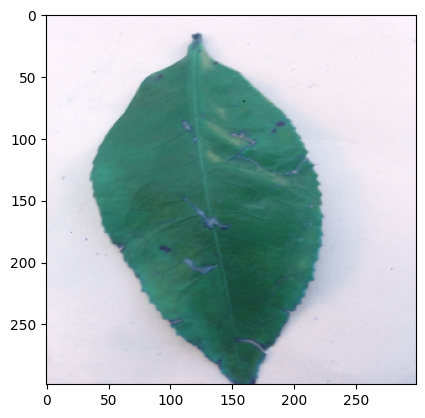

<Figure size 640x480 with 0 Axes>

SOURCE: class: 2, file: 2/IMG_20220503_154133.jpg
1/1 [==============================] - 0s 216ms/step
PREDICTED: class: 13, confidence: 0.546648


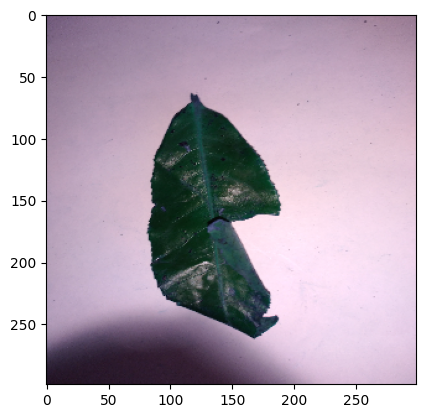

In [41]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict_reload(img)  # Use predict_reload here
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()


In [34]:
import time
import tensorflow as tf

t = time.time()

# Define the export path
export_path = "/tmp/saved_models/{}".format(int(t))

# Save the model as a SavedModel
tf.saved_model.save(model, export_path)

In [38]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

mkdir: cannot create directory ‘tflite_models’: File exists


91486812